# Chapter 2 - Production

In [1]:
!pip install -Uqq fastbook
!pip install -Uqq jmd_imagescraper

     |████████████████████████████████| 727kB 10.5MB/s 
     |████████████████████████████████| 194kB 24.1MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.2MB 24.3MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 


In [2]:
from pathlib import Path

import fastai.vision.all as vision
import fastai.vision.widgets as vision_widgets
import jmd_imagescraper.core as imagescraper
import requests

# Downloading Data

In [3]:
BEAR_PATH = Path('bears')

if not BEAR_PATH.exists():
  BEAR_PATH.mkdir()
  for bear in ['grizzly','black','teddy']:
      imagescraper.duckduckgo_search(
          BEAR_PATH, bear, f"{bear} bear", max_results=50, 
          img_layout=imagescraper.ImgLayout.All
      )

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Exception occured while retrieving https://tse2.mm.bing.net/th?id=OIP.STQb-2-u86xk3porV_JOxwHaE8&pid=Api
Duckduckgo search: teddy bear


# From DataBlocks, DataLoaders and Augmentation

In [4]:
bears = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.CategoryBlock), 
    get_items=vision.get_image_files, 
    splitter=vision.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=vision.parent_label,
    item_tfms=vision.Resize(128)
)

In [5]:
dls = bears.dataloaders(BEAR_PATH)

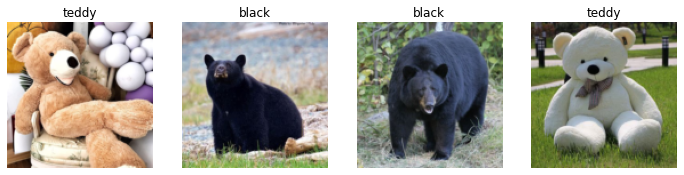

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

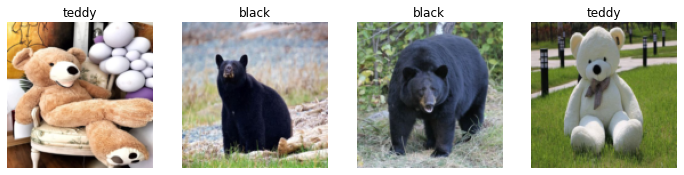

In [7]:
bears = bears.new(item_tfms=vision.Resize(128, vision.ResizeMethod.Squish))
dls = bears.dataloaders(BEAR_PATH)
dls.valid.show_batch(max_n=4, nrows=1)

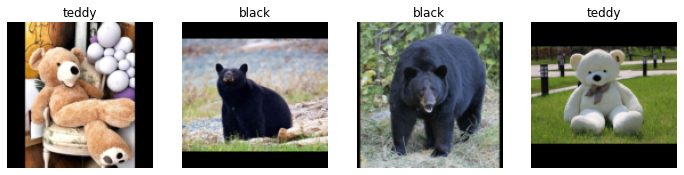

In [8]:
bears = bears.new(item_tfms=vision.Resize(128, vision.ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(BEAR_PATH)
dls.valid.show_batch(max_n=4, nrows=1)

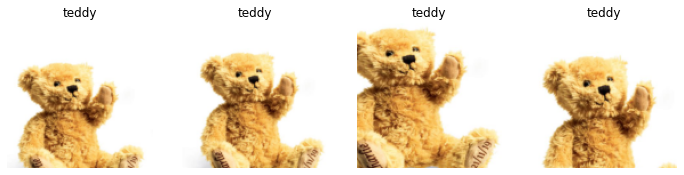

In [9]:
bears = bears.new(item_tfms=vision.RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(BEAR_PATH)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

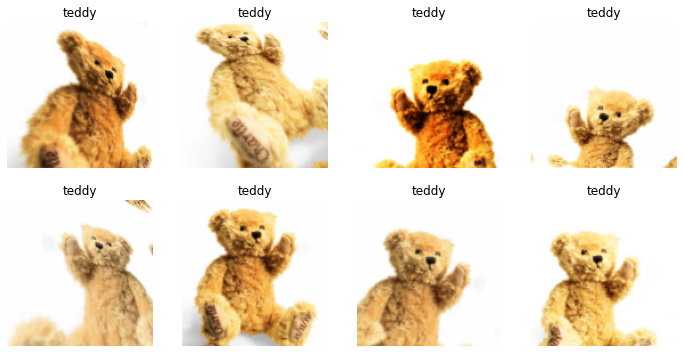

In [10]:
bears = bears.new(item_tfms=vision.Resize(128), batch_tfms=vision.aug_transforms(mult=2))
dls = bears.dataloaders(BEAR_PATH)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training, Evaluation and Data Cleaning

In [11]:
bears = bears.new(
    item_tfms=vision.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=vision.aug_transforms())
dls = bears.dataloaders(BEAR_PATH)

In [12]:
learn = vision.cnn_learner(dls, vision.resnet18, metrics=vision.error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.372428,2.664331,0.689655,00:03


epoch,train_loss,valid_loss,error_rate,time
0,2.140134,1.983547,0.689655,00:02
1,1.870020,0.576291,0.206897,00:01
2,1.481827,0.258729,0.103448,00:01
3,1.155667,0.194196,0.068965,00:01


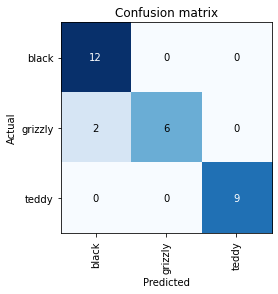

In [13]:
interp = vision.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

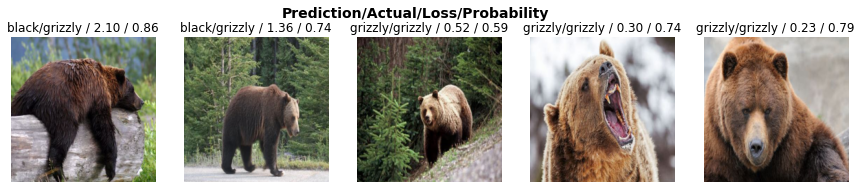

In [14]:
interp.plot_top_losses(5, nrows=1)

In [15]:
cleaner = vision_widgets.ImageClassifierCleaner(learn)
cleaner

In [16]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Inference

In [18]:
def which_bear(url):
    img = vision.PILImage.create(requests.get(url, stream=True).raw)
    bear, i ,probs = learn.predict(img)
    print(f"This is a {bear} bear")
    print(f"Probability: {probs[i].item():.6f}")
    return img.to_thumb(192)

This is a teddy bear
Probability: 0.999997


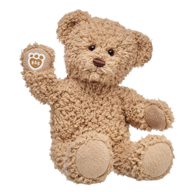

In [19]:
url = 'https://www.buildabear.co.uk/dw/image/v2/BBNG_PRD/on/demandware.static/-/Sites-buildabear-master/default/dwb8ba281b/26518x.jpg'
which_bear(url)

# Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
    - Hidden cameras, anything which isn't a pretty picture
2. Where do text models currently have a major deficiency?
    - The text looks convincing, but is nonsense.
3. What are possible negative societal implications of text generation models?
    - Mislead people - fake information, bad translations, etc.
4. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
    - Human in the loop, slow introduction to the real world.
5. What kind of tabular data is deep learning particularly good at?
    - Where we have high cardinality in columns (postcode)
6. What's a key downside of directly using a deep learning model for recommendation systems?
    - It isn't learning what you want, just patterns of similar behaviour.
7. What are the steps of the Drivetrain Approach?
    - Define your objective (not of the model, but of behaviour)
    - Identify what levers are under control
    - Identify what data we can gather
    - Model how pulling each lever changes the objective
8. How do the steps of the Drivetrain Approach map to a recommendation system?
    - Objective: increase sales of items customers would not have usually bought.
    - Levers: ordering of the recommendations
    - Data: What everyone else bought and how people behave with different recommendations
    - Model how ordering recommendation changes customer behaviour
9. Create an image recognition model using data you curate, and deploy it on the web.
    - Check out https://github.com/cqkh42/boris_vs_keir
10. What is DataLoaders?
    - DataLoaders is an object which yields gives batches of training and validation data
11. What four things do we need to tell fastai to create DataLoaders?
    - blocks: what the types of X and y are
    - get_items: some function to load the data
    - splitter: how to split training and validation
    - get_y: how to label the data
12. What does the splitter parameter to DataBlock do?
    - split the data into training and validation
13. How do we ensure a random split always gives the same validation set?
    - seed the randomness
14. What letters are often used to signify the independent and dependent variables?
    - X and y 
15. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
    - One crops, one pads nd one squishes. Different types of images might need different bits. Do we want to crop faces?
16. What is data augmentation? Why is it needed?
    - A rotated image is still an image - need to teach the mahine to learn generics
17. What is the difference between item_tfms and batch_tfms?
    - One is done item by item, the other on a whole batch
18. What is a confusion matrix?
    - What we guessed and what the answer was.
19. What does export save?
    - The model
20. What is it called when we use a model for getting predictions, instead of training?
    - Inference
21. What are IPython widgets?
    - Messy
22. When might you want to use CPU for deployment? When might GPU be better?
    - GPU is good for batching, but otherwise CPU does the trick for one offs.
23. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
    - Needs a connection to the server + might get overloaded.
24. What are three examples of problems that could occur when rolling out a bear warning system in practice?
    - People try it at night
    - Videos
    - noone takes pretty pictures of bears normally
25. What is "out-of-domain data"?
    - is this Boris or Keir (it is a tree)
26. What is "domain shift"?
    - People get older - facial recognition changes
27. What are the three steps in the deployment process?
    - Manual supervision/ approval
    - Limited scope rollout
    - Gradual expansion

# Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
    - Objectives - Stop fraudulent transactions
    - Levers - highlight potentially fraudlent requests
    - Data - historic requests
    - Models - model which learns what fraud looks like
2. When might it be best to avoid certain types of data augmentation?
    - When you might loose information - cropping faces means you might break it.
3. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
    - Recommendation engines - people spend all their money.
4. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.